## 1. Implementing the Merton Model

We will start by implementing the Merton model in Python. As you already know, the model has the following SDE:

$$
\begin{equation*}
    dS_t = \left( r - r_j \right) S_t dt + \sigma S_t dZ_t + J_t S_t dN_t
\end{equation*}
$$

with the following discretized form:

$$
\begin{equation*}
    S_t = S_{t-1} \left( e^{\left(r-r_j-\frac{\sigma^2}{2}\right)dt + \sigma \sqrt{dt} z_t^1}+
    \left(e^{\mu_j+\delta z_t^2}-1 \right) y_t \right)
\end{equation*}
$$

where $z_t^1$ and $z_t^2$ follow a standard normal and $y_t$ follows a Poisson process. Finally, $r_j$ equals to:

$$
\begin{equation*}
r_j = \lambda \left(e^{\mu_j+\frac{\delta^2}{2}}\right)-1
\end{equation*}
$$

Remember that, in order to obtain the parameters of the model, we will perform an exercise of calibration to option market prices. This will be, indeed, the first thing we will cover in the following Stochastic Modeling course. For now, let's assume these parameters as given and equal to:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss

In [20]:
import pandas as pd

SPY = pd.read_csv('SPY_wqu_data.csv')
print(SPY.head())  # Display first few rows
SPY.set_index('timestamp', inplace=True)
SPY.sort_index(inplace=True)
SPY=SPY[['close']]
SPY.head()

       volume        vw     open   close    high     low            timestamp   
0  45417600.0  102.2064  102.530  101.96  102.80  101.55  2003-09-10 04:00:00  \
1  38038300.0  102.3182  102.100  102.26  102.76  101.84  2003-09-11 04:00:00   
2  41159600.0  101.9165  101.910  102.45  102.64  101.35  2003-09-12 04:00:00   
3  20710600.0  102.2676  102.520  102.09  102.63  101.95  2003-09-15 04:00:00   
4  37103300.0  103.0466  102.232  103.58  103.64  102.17  2003-09-16 04:00:00   

   transactions  
0         25951  
1         22580  
2         26091  
3         15670  
4         19074  


,close
timestamp,
2003-09-10 04:00:00,101.96
2003-09-11 04:00:00,102.26
2003-09-12 04:00:00,102.45
2003-09-15 04:00:00,102.09
2003-09-16 04:00:00,103.58


In [72]:
SPY_return = (SPY["close"] / SPY["close"].shift(1)) - 1
SPY_return = SPY_return.to_frame()
SPY_std=round(float(SPY_return.std().iloc[0]),3)
SPY_return.columns = ["Simple Daily Returns"]

## Calibrate parameters using L-BFGS-B

In [80]:
#Let's also assume the following information for the current stock price, number of simulations in our Monte Carlo estimations, etc.

#r = 0.05  # Risk-free rate
sigma = float(round(SPY_std*np.sqrt(252),3)) # Volatility
#T = 1.0  # Maturity/time period (in years)
S0 = SPY.iloc[0,0]#100  # Current Stock Price

#Ite = 10000  # Number of simulations (paths)
#M = 50  # Number of steps
#dt = T / M  # Time-step

In [132]:
import numpy as np
from scipy.optimize import minimize
import random

# Define the Merton model pricing function (simplified)
def merton_price(params, r, T, M, Ite):
    dt=T/M
    lamb, mu, delta = params
    SM = np.zeros((M + 1, Ite))
    SM[0] = S0
    # rj
    rj = lamb * (np.exp(mu + 0.5 * delta**2) - 1)
    # Random numbers
    np.random.seed(256)
    z1 = np.random.standard_normal((M + 1, Ite))
    z2 = np.random.standard_normal((M + 1, Ite))
    y = np.random.poisson(lamb * dt, (M + 1, Ite))
    
    for t in range(1, M + 1):
        SM[t] = SM[t - 1] * (
            np.exp((r - rj - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z1[t])
            + (np.exp(mu + delta * z2[t]) - 1) * y[t]
            )
        SM[t] = np.maximum(
            SM[t], 0.00001
            )  # To ensure that the price never goes below zero!
        
    
    return SM


In [165]:
# Sample market option prices
SPY_arr = SPY.to_numpy()
SPY_arr= SPY_arr[:SM_avg.shape[0],:]#.reshape(SM_avg.shape)
SPY_arr.shape
market_prices = SPY_arr #np.array([10.5, 12.3, 15.2, 18.1, 20.7])

In [170]:
# Objective function: minimize squared error
def objective(params):
    #SM = merton_price(params,r=r, T=T)
    SM=pd.DataFrame(merton_price(params,r,T,M=50,Ite=10000))
    SM_avg = SM.mean(axis=1).to_frame(name='Average')
    SM_avg = SM_avg.to_numpy()
    
    return np.sum((SM_avg- market_prices) ** 2)


In [171]:
# Initial guess
initial_params = [0.1, -0.02, 0.05]

# Optimization using L-BFGS-B
result = minimize(objective, initial_params, method='L-BFGS-B', bounds=[(0.01, 1), (-0.1, 0.1), (0.01, 0.5)])

print("Optimized Parameters:", result.x)

Optimized Parameters: [0.08689315 0.03274894 0.19778357]


In [188]:
### using the optimized parameters we can simulate the stock prices again
params_opt = result.x
params_unopt = [0.75,-0.6,0.25]
SM_opt = merton_price(params_opt,r,T,M=50,Ite=10000)
SM_unopt = merton_price(params_unopt,r,T,M=50,Ite=10000)
SM_opt[:, 100:150].shape

(51, 50)

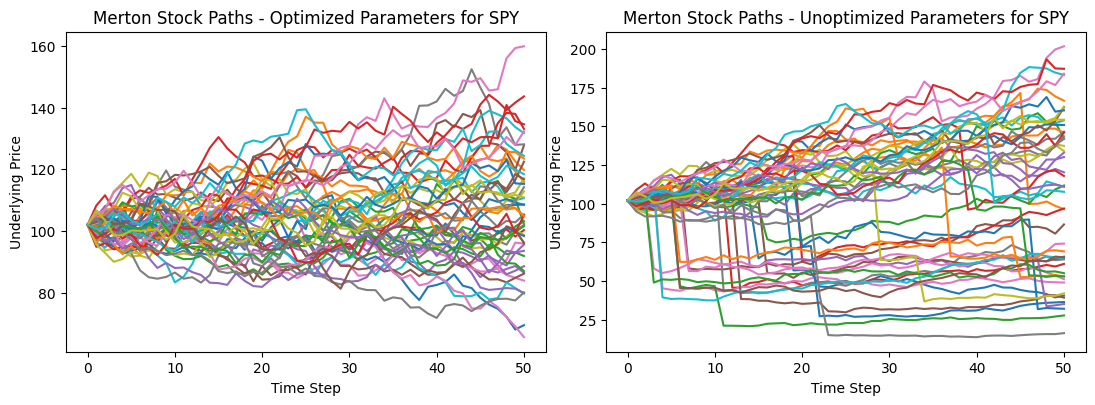

In [200]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 50, 51)
y1 = SM_opt[:, 100:150]
y2 = SM_unopt[:, 100:150]

plt.figure(figsize=(12, 4))  # Increase width to fit both plots

# First plot (left side)
ax1 = plt.axes([0.1, 0.1, 0.4, 0.8])  # [left, bottom, width, height]
ax1.plot(x, y1)
ax1.set_title("Merton Stock Paths - Optimized Parameters for SPY")
ax1.set_xlabel("Time Step")
ax1.set_ylabel("Underlying Price")

# Second plot (right side)
ax2 = plt.axes([0.55, 0.1, 0.4, 0.8])  # Adjust left position for second plot
ax2.plot(x, y2)
ax2.set_title("Merton Stock Paths - Unoptimized Parameters for SPY")
ax2.set_xlabel("Time Step")
ax2.set_ylabel("Underlying Price")

plt.show()

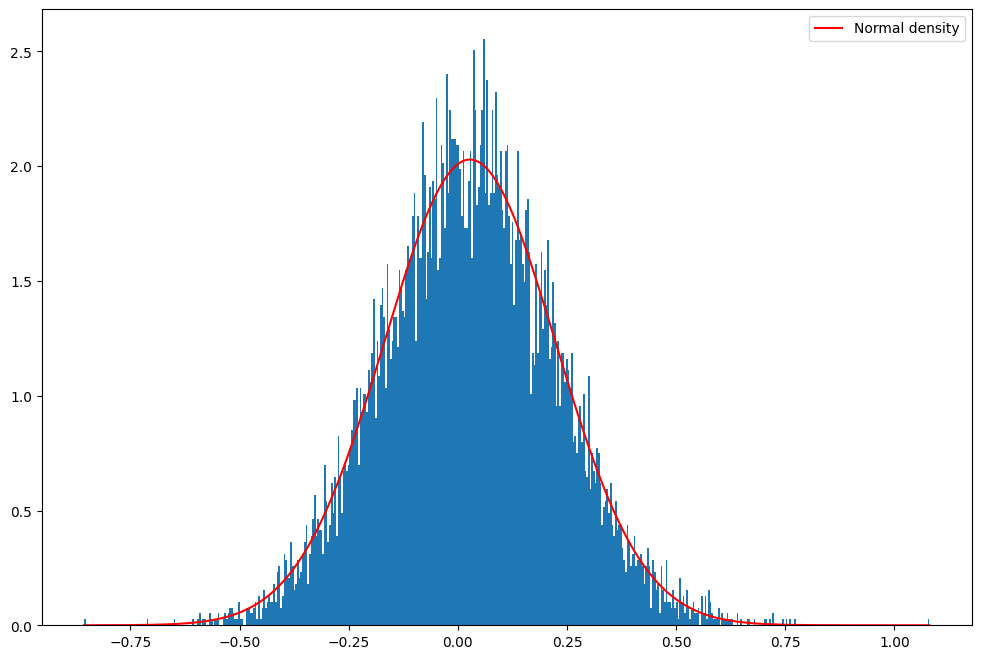

In [202]:
#What is the distribution of stock returns that this model produces?
retSM = np.log(SM_opt[-1, :] / S0)
x = np.linspace(retSM.min(), retSM.max(), 500)

plt.figure(figsize=(12, 8))
plt.hist(retSM, density=True, bins=500)
plt.plot(
    x, ss.norm.pdf(x, retSM.mean(), retSM.std()), color="r", label="Normal density"
)
plt.legend()
plt.show()


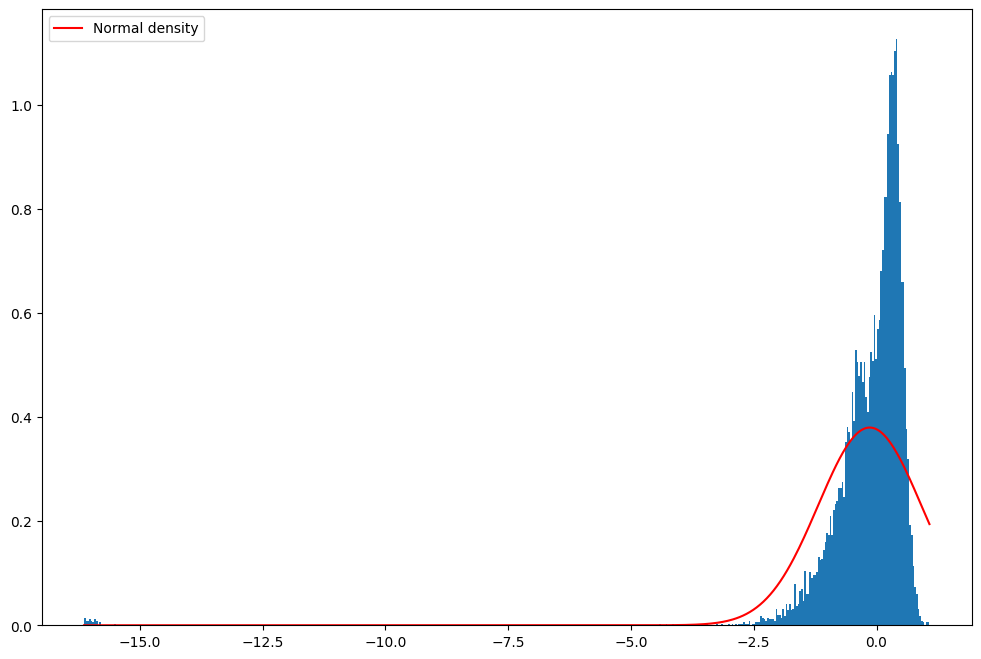

In [203]:
#What is the distribution of stock returns that this model produces?
retSM = np.log(SM_unopt[-1, :] / S0)
x = np.linspace(retSM.min(), retSM.max(), 500)

plt.figure(figsize=(12, 8))
plt.hist(retSM, density=True, bins=500)
plt.plot(
    x, ss.norm.pdf(x, retSM.mean(), retSM.std()), color="r", label="Normal density"
)
plt.legend()
plt.show()
